Ялунин Александр ИАД-1, \
PL=0.922

# Imports

In [0]:
import zipfile
import numpy as np
import pandas as pd
import os
import tqdm
import matplotlib 
%matplotlib inline
import matplotlib.pyplot as plt
import csv
import cv2
from itertools import islice

In [0]:
import time

In [0]:
import ast
from PIL import Image, ImageDraw

In [0]:
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential, save_model, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, GlobalAveragePooling2D, \
    BatchNormalization
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy

from keras.applications.mobilenet import MobileNet
from keras.applications.resnet50 import ResNet50

Using TensorFlow backend.


**Saving to Google Drive**

In [0]:
! pip install -U -q PyDrive

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download data from Kaggle

In [0]:
# we need to use python 3 version of Kaggle!
# remove python 2 version with `pip uninstall kaggle`
! pip3 install kaggle --upgrade

    100% |████████████████████████████████| 61kB 1.2MB/s 
    100% |████████████████████████████████| 245kB 3.8MB/s 
  Running setup.py bdist_wheel for kaggle ... - \ done
  Stored in directory: /root/.cache/pip/wheels/8b/21/3b/a0076243c6ae12a6215b2da515fe06b539aee7217b406e510e
  Running setup.py bdist_wheel for python-slugify ... - done
  Stored in directory: /root/.cache/pip/wheels/e3/65/da/2045deea3098ed7471eca0e2460cfbd3fdfe8c1d6fa6fcac92
Successfully built kaggle python-slugify


In [0]:
# get <token> from https://www.kaggle.com/<user>/account, click "Create New API Token", open json file
! KAGGLE_USERNAME=alexyalunin KAGGLE_KEY=1191c609419511bd8d9fd6972f716f9e kaggle competitions download -c quickdraw-doodle-recognition -f train_simplified.zip

100% 7.36G/7.37G [01:58<00:00, 92.4MB/s]
100% 7.37G/7.37G [01:58<00:00, 67.0MB/s]


In [0]:
# open zip file, will read everything from it
zf = zipfile.ZipFile("train_simplified.zip")

# Data generators from disk (no need to store in RAM)

In [0]:
class_labels = map(lambda x: x.replace(".csv", ""), zf.namelist())
NUM_CLASSES = len(class_labels)
class_to_idx = {c: idx for idx, c in enumerate(class_labels)}
class_labels[:5]

['fence', 'yoga', 'horse', 'sandwich', 'cat']

In [0]:
# function that counts file sizes
# %%time
# filesLenghts = {}
# for fn in zf.namelist():
#   with zf.open(fn) as f:
#     numline = len(f.readlines())
#     filesLenghts[fn]  = numline
    
# print filesLenghts

In [0]:
filesLenghts = {'tooth.csv': 125065, 'The Mona Lisa.csv': 121384, 'bandage.csv': 147615, 'ice cream.csv': 123134, 'soccer ball.csv': 125350, 'sheep.csv': 126122, 'crab.csv': 126931, 'police car.csv': 130025, 'owl.csv': 169633, 'megaphone.csv': 137335, 'animal migration.csv': 137848, 'moustache.csv': 179925, 'bracelet.csv': 119417, 'tree.csv': 144722, 'tornado.csv': 143272, 'bird.csv': 133573, 'hexagon.csv': 142436, 'headphones.csv': 118907, 'bathtub.csv': 174337, 'cake.csv': 124906, 'palm tree.csv': 121960, 'octopus.csv': 150153, 'pillow.csv': 118754, 'stop sign.csv': 119815, 'cookie.csv': 131354, 'squirrel.csv': 156884, 'keyboard.csv': 187767, 'pizza.csv': 130372, 'shark.csv': 126051, 'dolphin.csv': 121614, 'ant.csv': 124613, 'toilet.csv': 129889, 'van.csv': 165910, 'diamond.csv': 131588, 'hockey stick.csv': 130111, 'hot dog.csv': 182000, 'crocodile.csv': 127933, 'pig.csv': 186771, 'blueberry.csv': 127879, 'bed.csv': 113863, 'flying saucer.csv': 151967, 'rhinoceros.csv': 188485, 'bowtie.csv': 130284, 'sailboat.csv': 136507, 'traffic light.csv': 125322, 'swing set.csv': 119358, 'zebra.csv': 144609, 'pineapple.csv': 125072, 'fan.csv': 136159, 'horse.csv': 178287, 'stairs.csv': 128982, 'swan.csv': 152089, 'eraser.csv': 118340, 'shorts.csv': 124971, 'tractor.csv': 116678, 'camel.csv': 121400, 'The Eiffel Tower.csv': 134802, 'sword.csv': 123803, 'dresser.csv': 123396, 'eye.csv': 125889, 'baseball bat.csv': 123810, 'bench.csv': 128696, 'peas.csv': 161657, 'lollipop.csv': 128850, 'flashlight.csv': 239764, 'apple.csv': 144723, 'paintbrush.csv': 187003, 'windmill.csv': 120645, 'popsicle.csv': 126708, 'camouflage.csv': 172711, 'toe.csv': 153653, 'pear.csv': 116905, 'octagon.csv': 159475, 'square.csv': 125146, 'grapes.csv': 155306, 'key.csv': 160966, 'pants.csv': 144265, 'sweater.csv': 120185, 'snowflake.csv': 116686, 'mushroom.csv': 142168, 'foot.csv': 203087, 'pliers.csv': 172550, 'stitches.csv': 125193, 'leaf.csv': 125572, 'skateboard.csv': 128734, 'wine glass.csv': 132303, 'zigzag.csv': 120073, 'garden hose.csv': 121844, 'onion.csv': 132298, 'frying pan.csv': 123825, 'blackberry.csv': 128154, 'paper clip.csv': 127130, 'moon.csv': 121662, 'map.csv': 120630, 'mermaid.csv': 180305, 'rake.csv': 154640, 'matches.csv': 143970, 'screwdriver.csv': 116314, 'mug.csv': 152919, 'lantern.csv': 149913, 'submarine.csv': 124363, 'harp.csv': 285404, 'bulldozer.csv': 187410, 'firetruck.csv': 220696, 'brain.csv': 143034, 'remote control.csv': 119645, 'wheel.csv': 136660, 'feather.csv': 119911, 'crown.csv': 134090, 'candle.csv': 141546, 'angel.csv': 149737, 'laptop.csv': 261502, 'piano.csv': 116871, 'snowman.csv': 340030, 'pencil.csv': 122002, 'fire hydrant.csv': 137243, 'grass.csv': 123072, 'birthday cake.csv': 144983, 'dumbbell.csv': 157976, 'marker.csv': 319137, 'diving board.csv': 290240, 'string bean.csv': 119084, 'panda.csv': 113614, 'underwear.csv': 124549, 'computer.csv': 123886, 'postcard.csv': 125707, 'see saw.csv': 131937, 'parrot.csv': 185531, 'barn.csv': 151140, 'hat.csv': 222611, 'lighthouse.csv': 160904, 'calendar.csv': 321982, 'basketball.csv': 133794, 'sock.csv': 205716, 'monkey.csv': 127634, 'pool.csv': 133440, 'helmet.csv': 121900, 'carrot.csv': 132460, 'binoculars.csv': 124191, 'clock.csv': 120537, 'stove.csv': 116536, 'saxophone.csv': 118108, 'mosquito.csv': 123030, 'jacket.csv': 214125, 'pond.csv': 121621, 'calculator.csv': 128376, 'circle.csv': 122877, 'wristwatch.csv': 162646, 'cup.csv': 130722, 'toothpaste.csv': 131038, 'flip flops.csv': 121519, 'guitar.csv': 120452, 'house plant.csv': 122997, 'ladder.csv': 125390, 'church.csv': 164226, 'drill.csv': 136787, 'nose.csv': 197574, 'rabbit.csv': 155289, 'picture frame.csv': 122372, 'scissors.csv': 123391, 'airplane.csv': 151624, 'peanut.csv': 126627, 'donut.csv': 140752, 'hospital.csv': 167449, 'eyeglasses.csv': 225763, 'face.csv': 161667, 'house.csv': 135421, 'rain.csv': 134681, 'potato.csv': 329205, 'ceiling fan.csv': 115414, 'baseball.csv': 135376, 'teapot.csv': 126805, 'dishwasher.csv': 169760, 'steak.csv': 122043, 'fork.csv': 126078, 'lipstick.csv': 127624, 'floor lamp.csv': 166356, 'smiley face.csv': 124387, 'nail.csv': 158594, 'pickup truck.csv': 130741, 'golf club.csv': 194844, 'hammer.csv': 119013, 'boomerang.csv': 142683, 'line.csv': 143550, 'canoe.csv': 123768, 'beach.csv': 124939, 'goatee.csv': 190003, 'sun.csv': 133782, 'leg.csv': 116805, 'bucket.csv': 124065, 'helicopter.csv': 159939, 'asparagus.csv': 168103, 'door.csv': 120231, 'sandwich.csv': 131733, 'stereo.csv': 122445, 'hourglass.csv': 135958, 'arm.csv': 120952, 'lion.csv': 120950, 'mouth.csv': 134136, 'toaster.csv': 122435, 'car.csv': 182765, 'wine bottle.csv': 126374, 'ambulance.csv': 148005, 'sink.csv': 208411, 'hand.csv': 291774, 'basket.csv': 118459, 'chair.csv': 222707, 'bee.csv': 120891, 'hot tub.csv': 120280, 'cactus.csv': 131677, 'lobster.csv': 140176, 't-shirt.csv': 125234, 'alarm clock.csv': 123400, 'dragon.csv': 124363, 'couch.csv': 119663, 'speedboat.csv': 188581, 'skull.csv': 126175, 'cow.csv': 123084, 'bush.csv': 120521, 'rainbow.csv': 126846, 'mountain.csv': 128541, 'bread.csv': 120571, 'truck.csv': 131355, 'washing machine.csv': 120852, 'tennis racquet.csv': 231152, 'lightning.csv': 151561, 'river.csv': 133272, 'hockey puck.csv': 203302, 'motorbike.csv': 169932, 'finger.csv': 167958, 'frog.csv': 159048, 'campfire.csv': 133396, 'rollerskates.csv': 119773, 'hedgehog.csv': 120528, 'whale.csv': 116503, 'dog.csv': 152160, 'snail.csv': 133758, 'mailbox.csv': 130054, 'butterfly.csv': 118000, 'waterslide.csv': 185365, 'cell phone.csv': 121131, 'elephant.csv': 126970, 'broccoli.csv': 132827, 'axe.csv': 124123, 'triangle.csv': 123171, 'spider.csv': 209448, 'The Great Wall of China.csv': 193016, 'mouse.csv': 178827, 'hamburger.csv': 129673, 'parachute.csv': 127320, 'bear.csv': 134763, 'spoon.csv': 125029, 'hurricane.csv': 136246, 'fish.csv': 134151, 'flower.csv': 144819, 'yoga.csv': 280443, 'television.csv': 123138, 'sleeping bag.csv': 119692, 'bat.csv': 118115, 'suitcase.csv': 126443, 'shovel.csv': 117195, 'necklace.csv': 120581, 'stethoscope.csv': 153795, 'jail.csv': 120132, 'garden.csv': 158528, 'cloud.csv': 120266, 'school bus.csv': 122042, 'roller coaster.csv': 143571, 'kangaroo.csv': 174471, 'cat.csv': 123203, 'belt.csv': 191120, 'train.csv': 127949, 'ocean.csv': 131494, 'envelope.csv': 134864, 'cannon.csv': 141395, 'bridge.csv': 133011, 'saw.csv': 121257, 'chandelier.csv': 167503, 'cello.csv': 149726, 'purse.csv': 123321, 'squiggle.csv': 118442, 'fence.csv': 129427, 'radio.csv': 135729, 'bicycle.csv': 126528, 'beard.csv': 165203, 'microphone.csv': 120571, 'trombone.csv': 184760, 'cruise ship.csv': 123411, 'vase.csv': 126476, 'raccoon.csv': 119589, 'sea turtle.csv': 119877, 'giraffe.csv': 127183, 'duck.csv': 135481, 'teddy-bear.csv': 179569, 'knee.csv': 267541, 'castle.csv': 122535, 'table.csv': 128022, 'tiger.csv': 121068, 'trumpet.csv': 169548, 'book.csv': 119365, 'scorpion.csv': 165690, 'violin.csv': 217261, 'telephone.csv': 127886, 'flamingo.csv': 124570, 'strawberry.csv': 122302, 'microwave.csv': 130534, 'light bulb.csv': 120880, 'toothbrush.csv': 124829, 'tent.csv': 131528, 'snorkel.csv': 154534, 'streetlight.csv': 123281, 'skyscraper.csv': 183710, 'paint can.csv': 123447, 'elbow.csv': 126254, 'bus.csv': 166209, 'coffee cup.csv': 183433, 'watermelon.csv': 132940, 'bottlecap.csv': 153208, 'power outlet.csv': 169463, 'star.csv': 137620, 'cooler.csv': 271445, 'banana.csv': 307937, 'oven.csv': 206911, 'backpack.csv': 125802, 'crayon.csv': 129954, 'clarinet.csv': 126215, 'hot air balloon.csv': 126351, 'passport.csv': 150266, 'ear.csv': 122898, 'fireplace.csv': 155571, 'shoe.csv': 120232, 'compass.csv': 127610, 'umbrella.csv': 124085, 'snake.csv': 122274, 'broom.csv': 116928, 'anvil.csv': 126232, 'spreadsheet.csv': 170201, 'drums.csv': 137300, 'penguin.csv': 253792, 'camera.csv': 128773}


In [0]:
# fl = [129427, 280443, 178287, 131733, 123203, 172711, 123030, 131937, 132298, 155306, 167503, 125193, 208411, 169548, 121131, 183710, 135958, 140752, 115414, 130284, 127624, 126443, 121662, 169760, 180305, 127933, 121068, 184760, 126351, 120571, 153208, 128541, 133440, 122274, 152160, 148005, 125802, 157976, 126254, 159048, 116314, 137243, 118442, 123396, 124123, 130054, 141395, 134763, 291774, 129889, 121844, 231152, 130722, 137300, 222611, 124065, 119815, 119645, 160966, 253792, 131354, 128154, 120232, 126708, 123411, 155289, 170201, 130534, 124613, 185531, 126374, 118115, 125322, 116503, 136660, 130111, 156884, 113614, 143550, 122372, 167958, 136507, 127610, 134136, 118340, 125390, 128696, 123825, 190003, 122042, 121400, 124570, 123810, 166356, 120528, 122445, 133011, 132827, 127879, 174337, 271445, 183433, 123072, 130741, 153653, 127634, 119084, 125350, 120073, 159939, 124387, 186771, 159475, 126175, 167449, 220696, 125572, 137335, 144723, 116536, 151561, 155571, 307937, 126078, 203087, 121257, 123321, 123803, 118108, 120852, 127320, 123400, 126232, 144983, 340030, 124939, 142683, 154534, 124549, 118754, 187767, 119692, 116905, 164226, 131494, 118907, 160904, 137620, 133396, 154640, 126051, 128773, 120452, 134681, 321982, 126476, 144819, 120185, 152919, 120132, 127886, 122002, 188581, 165690, 151967, 214125, 120571, 120266, 319137, 117195, 119589, 122043, 161667, 143034, 150266, 133794, 131588, 127949, 131528, 165203, 121519, 174471, 143272, 122997, 149913, 123768, 122535, 290240, 151140, 113863, 158594, 203302, 126627, 120521, 166209, 137848, 119365, 133272, 130372, 126122, 120950, 125707, 119877, 143571, 123134, 149726, 122302, 136159, 136787, 128376, 150153, 125072, 142436, 124363, 126528, 125146, 116678, 122435, 118000, 285404, 129954, 125234, 120581, 187003, 147615, 120952, 123447, 182000, 119358, 120231, 121614, 178827, 116871, 142168, 197574, 133573, 134151, 128022, 120880, 134090, 135481, 134802, 135421, 121960, 131677, 120280, 120891, 119417, 132303, 121384, 187410, 123391, 179925, 169633, 225763, 121900, 126805, 123281, 141546, 152089, 120630, 149737, 205716, 188485, 162646, 158528, 116805, 194844, 136246, 143970, 124085, 144265, 261502, 121621, 125029, 168103, 128982, 125889, 124363, 123084, 119663, 116928, 239764, 329205, 135376, 144722, 122877, 135729, 120537, 119013, 133782, 153795, 122898, 132940, 124906, 127130, 120645, 217261, 191120, 172550, 126970, 267541, 123171, 119911, 123886, 126846, 128850, 130025, 124971, 128734, 119773, 144609, 169932, 209448, 133758, 124829, 124191, 185365, 131355, 222707, 151624, 161657, 134864, 125065, 193016, 126931, 165910, 126215, 182765, 132460, 118459, 116686, 169463, 129673, 140176, 131038, 179569, 123138, 206911, 127183]
# _ = plt.hist(filesLenghts, bins=150)
# np.min(fl)

In [0]:
LAST_LINE=0
STEPS_PER_EPOCH = 1000

After each epoch, 32 files are selected to generate images, one generator can be selected several times to generate images for 1 batch, they do not record the line in which the iterator stops at the end of epoch, therefore many images are seen several times while others are never, even some classes can never be seen, therefore this leads to a huge variance problem. The new generator I have written solves this problem, it records the line (LAST_LINE) the iterator stopped last time and it restarts from the beginning of file efficiently enough.

In [0]:
# loop through file eternally
# def get_eternal_csv_generator(fn, debug=False):
#     while True:
#         with zf.open(fn) as f:
#             f.readline()  # skip header
#             for line in csv.reader(islice(f, LAST_LINE, None), delimiter=',', quotechar='"'):
#                 yield line[1], line[5]
#             if debug:
#                 print fn, "is done, starting from the beginning..."

def get_eternal_csv_generator(fn, debug=False):
    while True:
        with zf.open(fn) as f:
            f.readline() # skip header
            if STEPS_PER_EPOCH > filesLenghts[fn] - LAST_LINE:
                if filesLenghts[fn] > LAST_LINE:
                    _line = 0
                else:
                    _line = LAST_LINE % filesLenghts[fn]
                for line in csv.reader(islice(f, _line, None), delimiter=',', quotechar='"'):
                    yield line[1], line[5]
            else:
                for line in csv.reader(islice(f, LAST_LINE, None), delimiter=',', quotechar='"'):
                    yield line[1], line[5]
            if debug:
                print fn, "is done, starting from the beginning..."

In [0]:
a = get_eternal_csv_generator("fence.csv").next()
a

('[[[14, 14], [82, 8]], [[55, 56], [62, 11]], [[97, 97], [90, 14]], [[152, 146, 145], [70, 26, 0]], [[0, 57, 196, 255], [34, 36, 47, 47]]]',
 'fence')

If batch_size is 340, then we just take 1 sample from each class

In [0]:
def raw_batch_generator(batch_size, debug=False):
    print 'LAST_LINE:', LAST_LINE
    generators = np.array([get_eternal_csv_generator(fn, debug) for fn in zf.namelist()])
    while True:
        if batch_size != 340:
            random_indices = np.random.randint(0, len(generators), size=batch_size)
            yield [gen.next() for gen in generators[random_indices]]
        else:
            yield [gen.next() for gen in generators]

# Images generator

Added grayscale to strokes (copypasted from Kaggle)

In [0]:
BASE_SIZE=128

In [0]:
# copy-paste from https://www.kaggle.com/jpmiller/image-based-cnn
# faster conversion function

# def draw_it(strokes, img_size, time_color=True):
#     image = Image.new("P", (256, 256), color=255)
#     image_draw = ImageDraw.Draw(image)
#     for t, stroke in enumerate(ast.literal_eval(strokes)):
#         for i in range(len(stroke[0])-1):
#             color = 255 - min(t, 10) * 13 if time_color else 255
#             image_draw.line([stroke[0][i], 
#                              stroke[1][i],
#                              stroke[0][i+1], 
#                              stroke[1][i+1]],
#                             fill=color, width=6)
#     image = image.resize((img_size, img_size))
#     return np.array(image, dtype=np.uint8)

# copy-paste from https://www.kaggle.com/gaborfodor/greyscale-mobilenet-lb-0-892

def draw_cv2(raw_strokes, size=BASE_SIZE, lw=6, time_color=True):
    img = np.zeros((256, 256), np.uint8)
    for t, stroke in enumerate(ast.literal_eval(raw_strokes)):
        for i in range(len(stroke[0]) - 1):
            color = 255 - min(t, 10) * 13 if time_color else 255
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]),
                         (stroke[0][i + 1], stroke[1][i + 1]), color, lw)
    if size != 256:
        return cv2.resize(img, (size, size))
    else:
        return img

In [0]:
def images_and_labels_generator(batch_size, img_size):
    for batch in raw_batch_generator(batch_size):
        batch_images = []
        batch_labels = []
        for e in batch:
            batch_images.append(draw_cv2(e[0], img_size))
            batch_labels.append(e[1])
        batch_images = np.stack(batch_images, axis=0)
        yield batch_images, batch_labels

As you can see a picture now records the information about the sequence of strokes

LAST_LINE: 0


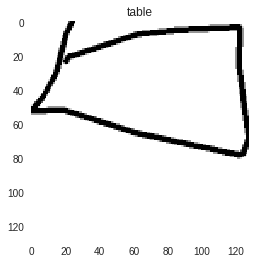

In [0]:
b = images_and_labels_generator(32, 128).next()
plt.imshow(b[0][10, :, :])
plt.title(b[1][10])
plt.grid('off')
plt.show()

# Train utils


In [0]:
# reset graph when you change architecture!
def reset_tf_session():
    curr_session = tf.get_default_session()
    # close current session
    if curr_session is not None:
        curr_session.close()
    # reset graph
    K.clear_session()
    # create new session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.InteractiveSession(config=config)
    K.set_session(s)
    return s

In [0]:
def train_iterator(batch_size, img_size=BASE_SIZE):
    for batch in images_and_labels_generator(batch_size, img_size):
        images = batch[0].astype('float32')
        ### YOUR CODE HERE: normalize images!
        images = np.divide(images, 255.)
        images = np.expand_dims(images, -1)
        labels = keras.utils.to_categorical(map(class_to_idx.get, batch[1]), NUM_CLASSES)
        yield images, labels

In [0]:
sample_batch = train_iterator(32, 128).next()
print sample_batch[0].shape
print sample_batch[1].shape

LAST_LINE: 0
(32, 128, 128, 1)
(32, 340)


In [0]:
def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

### Callbacks + Saving to Google Drive

In [0]:
class ModelSaveCallback(keras.callbacks.Callback):
    def __init__(self, model_name):
        super(ModelSaveCallback, self).__init__()
        self.model_name = model_name

    def on_epoch_end(self, epoch, logs=None):
        model_filename = self.model_name+"_"+str(epoch + 1)
        save_model(self.model, model_filename) 
        model_file = drive.CreateFile({'title' : model_filename})
        model_file.SetContentFile(model_filename)
        model_file.Upload()
        drive.CreateFile({'id': model_file.get('id')})
        print("Uploaded to Drive: {}".format(model_file.get('id')))
        print("Model saved as: {}".format(model_filename))

In [0]:
# model_filename = 'model_3_40'
# model_file = drive.CreateFile({'title' : model_filename})
# model_file.SetContentFile(model_filename)
# model_file.Upload()
# drive.CreateFile({'id': model_file.get('id')})

# Models

## Model 1

In [0]:
def make_model_1():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """
    model = Sequential()
    model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(64, 64, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(NUM_CLASSES, activation="softmax"))
    
    return model

s = reset_tf_session()
model_1 = make_model_1()
model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 128)       1280      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 64)        73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 32)        18464     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
__________

In [0]:
model_1.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.adam(lr=0.002, clipnorm=5.),
    metrics=[categorical_accuracy, top_3_accuracy]
)

In [0]:
%%time

MODEL_NAME = "model_1"
BATCH_SIZE = 680
STEPS_PER_EPOCH = 500
EPOCHS=20

last_finished_epoch = 10

if last_finished_epoch > 0:
    s = reset_tf_session()
    model_filename = MODEL_NAME+"_"+str(last_finished_epoch)
    # Download from Drive
#     last_weight_file = drive.CreateFile({'id': '186Z-YIvnOHN40w-rNuGXdRwVycQePTab'}) 
#     last_weight_file.GetContentFile('model_1_10')
    model_1 = load_model(model_filename, custom_objects={"top_3_accuracy": top_3_accuracy})

hist_1 = model_1.fit_generator(
    train_iterator(BATCH_SIZE, 64), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    callbacks=[ModelSaveCallback(MODEL_NAME)],
    verbose=1,
    initial_epoch=last_finished_epoch
)

Epoch 11/20
500/500 [==============================] - 234s 467ms/step - loss: 1.5759 - categorical_accuracy: 0.6210 - top_3_accuracy: 0.8031
Uploaded to Drive
Model saved in model_1_11
Epoch 12/20
500/500 [==============================] - 232s 463ms/step - loss: 1.5481 - categorical_accuracy: 0.6264 - top_3_accuracy: 0.8082
Uploaded to Drive
Model saved in model_1_12
Epoch 13/20
500/500 [==============================] - 233s 466ms/step - loss: 1.5418 - categorical_accuracy: 0.6276 - top_3_accuracy: 0.8087
Uploaded to Drive
Model saved in model_1_13
Epoch 14/20
 14/500 [..............................] - ETA: 3:45 - loss: 1.5496 - categorical_accuracy: 0.6271 - top_3_accuracy: 0.8064

KeyboardInterrupt: ignored

Stopped after 14, since accuracy didn't increase

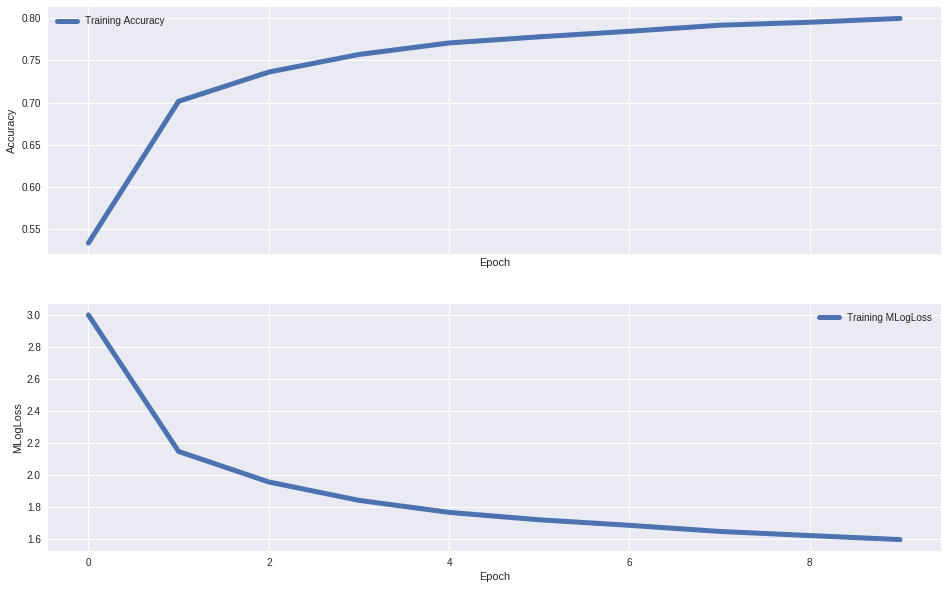

In [0]:
hist_df = pd.DataFrame(hist_1.history)
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
axs[0].plot(hist_df['top_3_accuracy'], lw=5, label='Training Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].grid("on")
axs[0].legend(loc=0)
axs[1].plot(hist_df.loss, lw=5, label='Training MLogLoss')
axs[1].set_ylabel('MLogLoss')
axs[1].set_xlabel('Epoch')
axs[1].grid("on")a
axs[1].legend(loc=0)
plt.show();

<30min of training time, 1.6m parameters, PL=0.746


## Model 2

Lets add BatchNorm, hence decrease BATCH_SIZE

In [0]:
def make_model_2():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """
    model = Sequential()
    model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(64, 64, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(NUM_CLASSES, activation="softmax"))
    
    return model

s = reset_tf_session()
model_2 = make_model_2()
model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 128)       1280      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 128)       512       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 64)        73792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 30, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 32)        18464     
__________

In [0]:
model_2.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.adam(lr=0.002, clipnorm=5.),
    metrics=[categorical_accuracy, top_3_accuracy]
)

In [0]:
%%time
BATCH_SIZE=32
STEPS_PER_EPOCH=2000
EPOCH=30

MODEL_NAME = "model_2"
last_finished_epoch = 25

if last_finished_epoch > 0:
    s = reset_tf_session()
    model_filename = MODEL_NAME+"_"+str(last_finished_epoch)
    model_2 = load_model(model_filename, custom_objects={"top_3_accuracy": top_3_accuracy})

hist_2 = model_2.fit_generator(
    train_iterator(BATCH_SIZE), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCH,
    callbacks=[ModelSaveCallback(MODEL_NAME)],
    verbose=1,
    initial_epoch=last_finished_epoch
)

Epoch 26/30
2000/2000 [==============================] - 118s 59ms/step - loss: 1.6393 - categorical_accuracy: 0.6043 - top_3_accuracy: 0.7894
Uploaded to Drive
Model saved in model_2_26
Epoch 27/30
2000/2000 [==============================] - 118s 59ms/step - loss: 1.6370 - categorical_accuracy: 0.6054 - top_3_accuracy: 0.7917
Uploaded to Drive
Model saved in model_2_27
Epoch 28/30
2000/2000 [==============================] - 117s 59ms/step - loss: 1.6205 - categorical_accuracy: 0.6090 - top_3_accuracy: 0.7935
Uploaded to Drive
Model saved in model_2_28
Epoch 29/30
2000/2000 [==============================] - 118s 59ms/step - loss: 1.6118 - categorical_accuracy: 0.6123 - top_3_accuracy: 0.7922
Uploaded to Drive
Model saved in model_2_29
Epoch 30/30
2000/2000 [==============================] - 117s 59ms/step - loss: 1.6234 - categorical_accuracy: 0.6051 - top_3_accuracy: 0.7920
Uploaded to Drive
Model saved in model_2_30
CPU times: user 10min 4s, sys: 1min 16s, total: 11min 20s
Wall ti

~1hour, 1.6m parameters, PL=0.706

My suggestion is that the iterator performs not well enough because we don't call all image generators equally, hence our model does not generalize well with small BATCH_SIZE, I would recommend increase BATCH_SIZE

## Model 3

More filters+more layers+AveragePooling instead of flattening

In [0]:
def make_model_3():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(64, 64, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Conv2D(1024, kernel_size=(1, 1), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(NUM_CLASSES, activation="softmax"))
    
    return model

s = reset_tf_session()
model_3 = make_model_3()
model_3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       73856     
__________

In [0]:
model_3.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.adam(clipnorm=5.),
    metrics=[categorical_accuracy, top_3_accuracy]
)

In [0]:
%%time
BATCH_SIZE=32
STEPS_PER_EPOCH=2000
EPOCHS=40

MODEL_NAME = "model_3"
last_finished_epoch = 30

if last_finished_epoch > 0:
    s = reset_tf_session()
    model_filename = MODEL_NAME+"_"+str(last_finished_epoch)
    model_3 = load_model(model_filename, custom_objects={"top_3_accuracy": top_3_accuracy})

hist_3 = model_3.fit_generator(
    train_iterator(BATCH_SIZE), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    callbacks=[ModelSaveCallback(MODEL_NAME)],
    verbose=1,
    initial_epoch=last_finished_epoch
)

Epoch 1/30
2000/2000 [==============================] - 139s 69ms/step - loss: 3.8392 - categorical_accuracy: 0.1951 - top_3_accuracy: 0.3517
Uploaded to Drive
Model saved in model_3_1
Epoch 2/30
2000/2000 [==============================] - 138s 69ms/step - loss: 2.6432 - categorical_accuracy: 0.3789 - top_3_accuracy: 0.5973
Uploaded to Drive
Model saved in model_3_2
Epoch 3/30
2000/2000 [==============================] - 138s 69ms/step - loss: 2.3084 - categorical_accuracy: 0.4507 - top_3_accuracy: 0.6645
Uploaded to Drive
Model saved in model_3_3
Epoch 4/30
2000/2000 [==============================] - 138s 69ms/step - loss: 2.1139 - categorical_accuracy: 0.4875 - top_3_accuracy: 0.7065
Uploaded to Drive
Model saved in model_3_4
Epoch 5/30
2000/2000 [==============================] - 138s 69ms/step - loss: 1.9831 - categorical_accuracy: 0.5189 - top_3_accuracy: 0.7300
Uploaded to Drive
Model saved in model_3_5
Epoch 6/30
2000/2000 [==============================] - 137s 68ms/step - lo

Exception tensorflow.python.framework.errors_impl.CancelledError: CancelledError() in <bound method _Callable.__del__ of <tensorflow.python.client.session._Callable object at 0x7f1232c5f690>> ignored


2000/2000 [==============================] - 139s 69ms/step - loss: 1.7693 - categorical_accuracy: 0.5655 - top_3_accuracy: 0.7685
Uploaded to Drive
Model saved in model_3_8
Epoch 9/30
2000/2000 [==============================] - 139s 69ms/step - loss: 1.7267 - categorical_accuracy: 0.5769 - top_3_accuracy: 0.7764
Uploaded to Drive
Model saved in model_3_9
Epoch 10/30
2000/2000 [==============================] - 138s 69ms/step - loss: 1.6801 - categorical_accuracy: 0.5860 - top_3_accuracy: 0.7855
Uploaded to Drive
Model saved in model_3_10
Epoch 11/30
2000/2000 [==============================] - 136s 68ms/step - loss: 1.6465 - categorical_accuracy: 0.5957 - top_3_accuracy: 0.7909
Uploaded to Drive
Model saved in model_3_11
Epoch 12/30
2000/2000 [==============================] - 140s 70ms/step - loss: 1.6184 - categorical_accuracy: 0.6015 - top_3_accuracy: 0.7939
Uploaded to Drive
Model saved in model_3_12
Epoch 13/30
2000/2000 [==============================] - 138s 69ms/step - loss: 

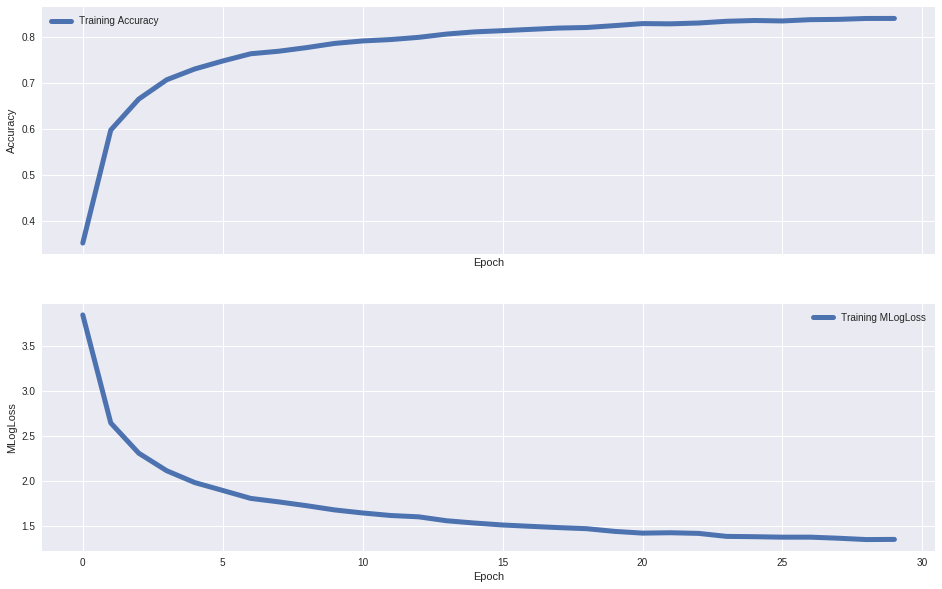

In [0]:
hist_df = pd.DataFrame(hist_3.history)
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
axs[0].plot(hist_df['top_3_accuracy'], lw=5, label='Training Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].grid("on")
axs[0].legend(loc=0)
axs[1].plot(hist_df.loss, lw=5, label='Training MLogLoss')
axs[1].set_ylabel('MLogLoss')
axs[1].set_xlabel('Epoch')
axs[1].grid("on")
axs[1].legend(loc=0)
plt.show();

1 hour, PL=0.789, lets train 10 more epochs

In [0]:
%%time
BATCH_SIZE=32
STEPS_PER_EPOCH=2000
EPOCHS=40

MODEL_NAME = "model_3"
last_finished_epoch = 30

if last_finished_epoch > 0:
    s = reset_tf_session()
    model_filename = MODEL_NAME+"_"+str(last_finished_epoch)
    model_3 = load_model(model_filename, custom_objects={"top_3_accuracy": top_3_accuracy})

hist_3 = model_3.fit_generator(
    train_iterator(BATCH_SIZE), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    callbacks=[ModelSaveCallback(MODEL_NAME)],
    verbose=1,
    initial_epoch=last_finished_epoch
)

Epoch 31/40
2000/2000 [==============================] - 137s 68ms/step - loss: 1.3424 - categorical_accuracy: 0.6647 - top_3_accuracy: 0.8417
Uploaded to Drive
Model saved in model_3_31
Epoch 32/40
2000/2000 [==============================] - 136s 68ms/step - loss: 1.3291 - categorical_accuracy: 0.6680 - top_3_accuracy: 0.8452
Uploaded to Drive
Model saved in model_3_32
Epoch 33/40
2000/2000 [==============================] - 138s 69ms/step - loss: 1.3280 - categorical_accuracy: 0.6690 - top_3_accuracy: 0.8432
Uploaded to Drive
Model saved in model_3_33
Epoch 34/40
2000/2000 [==============================] - 137s 69ms/step - loss: 1.3060 - categorical_accuracy: 0.6704 - top_3_accuracy: 0.8472
Uploaded to Drive
Model saved in model_3_34
Epoch 35/40
2000/2000 [==============================] - 135s 67ms/step - loss: 1.3065 - categorical_accuracy: 0.6715 - top_3_accuracy: 0.8473
Uploaded to Drive
Model saved in model_3_35
Epoch 36/40
2000/2000 [==============================] - 137s 68m

PL=0.800 🎉

A good result but still not enough, I would still recommend increase BATCH_SIZE

## Data Augmentation

In [0]:
from keras.preprocessing.image import ImageDataGenerator

In [0]:
image_gen = ImageDataGenerator(
    rotation_range=40,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='constant',
    cval=0
)

Lets creare image generator with augmentation 

In [0]:
def images_and_labels_generator_with_augm(batch_size, img_size):
    for batch in raw_batch_generator(batch_size):
        batch_images = []
        batch_labels = []
        for e in batch:
            image = draw_cv2(e[0], img_size)
            image = np.tile(np.expand_dims(image, axis=2), (1, 1, 3))
            image = image_gen.random_transform(image)[:, :, 0]
            batch_images.append(image)
            batch_labels.append(e[1])
        batch_images = np.stack(batch_images, axis=0)
        yield batch_images, batch_labels

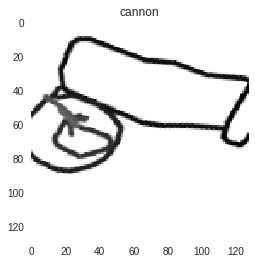

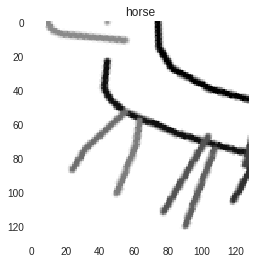

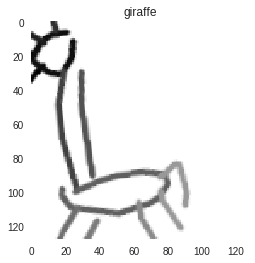

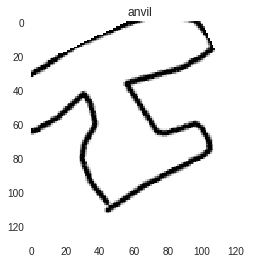

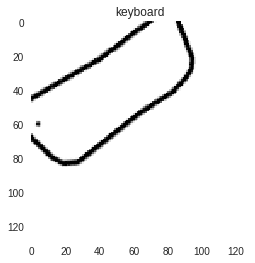

In [0]:
b = images_and_labels_generator_with_augm(32, 128).next()
for i in range(5):
    plt.imshow(b[0][i, :, :])
    plt.title(b[1][i])
    plt.grid('off')
    plt.show()


In [0]:
def train_iterator_with_augm(batch_size, img_size=BASE_SIZE):
    for batch in images_and_labels_generator_with_augm(batch_size, img_size):
        images = batch[0].astype('float32')
        ### YOUR CODE HERE: normalize images!
        images = np.divide(images, 255.)
        images = np.expand_dims(images, -1)
        labels = keras.utils.to_categorical(map(class_to_idx.get, batch[1]), NUM_CLASSES)
        yield images, labels

## Model 4 (using augmentation)

Lets train third model (from 40 epoch's checkpoint) on augmented data

In [0]:
%%time
BATCH_SIZE=32
STEPS_PER_EPOCH=2000
EPOCHS=30

MODEL_NAME = "model_4"
last_finished_epoch = 0

s = reset_tf_session()
model_filename = "model_3_40"
model_3 = load_model(model_filename, custom_objects={"top_3_accuracy": top_3_accuracy})

hist_4 = model_3.fit_generator(
    train_iterator_with_augm(BATCH_SIZE, 64), # changed iterator
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    callbacks=[ModelSaveCallback(MODEL_NAME)],
    verbose=1,
    initial_epoch=last_finished_epoch
)

Epoch 1/30
2000/2000 [==============================] - 177s 89ms/step - loss: 2.1305 - categorical_accuracy: 0.4921 - top_3_accuracy: 0.6926
Uploaded to Drive
Model saved in model_4_1
Epoch 2/30
2000/2000 [==============================] - 178s 89ms/step - loss: 1.9135 - categorical_accuracy: 0.5333 - top_3_accuracy: 0.7359
Uploaded to Drive
Model saved in model_4_2
Epoch 3/30
2000/2000 [==============================] - 177s 88ms/step - loss: 1.8414 - categorical_accuracy: 0.5495 - top_3_accuracy: 0.7500
Uploaded to Drive
Model saved in model_4_3
Epoch 4/30
2000/2000 [==============================] - 176s 88ms/step - loss: 1.7982 - categorical_accuracy: 0.5595 - top_3_accuracy: 0.7569
Uploaded to Drive
Model saved in model_4_4
Epoch 5/30
2000/2000 [==============================] - 176s 88ms/step - loss: 1.7636 - categorical_accuracy: 0.5653 - top_3_accuracy: 0.7639
Uploaded to Drive
Model saved in model_4_5
Epoch 6/30
2000/2000 [==============================] - 176s 88ms/step - lo

1.5 hour, PL=0.798

The same quality, the model performs neither worse nor better

## Model 5

Lets take third model and increase BATCH_SIZE and IMG_SIZE

In [0]:
def make_model_5():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(128, 128, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Conv2D(1024, kernel_size=(1, 1), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(NUM_CLASSES, activation="softmax"))
    
    return model

In [0]:
s = reset_tf_session()
model_5 = make_model_5()

model_5.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.adam(clipnorm=5.),
    metrics=[categorical_accuracy, top_3_accuracy]
)

In [0]:
print(model_5.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 32)      320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       73856     
__________

In [0]:
%%time
BATCH_SIZE=340
STEPS_PER_EPOCH=2000
EPOCHS=5
IMG_SIZE=128

MODEL_NAME = "model_5"
last_finished_epoch = 0

if last_finished_epoch > 0:
    s = reset_tf_session()
    model_filename = MODEL_NAME+"_"+str(last_finished_epoch)
    model_5 = load_model(model_filename, custom_objects={"top_3_accuracy": top_3_accuracy})

model_5.fit_generator(
    train_iterator(BATCH_SIZE, IMG_SIZE), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    callbacks=[ModelSaveCallback(MODEL_NAME)],
    verbose=1,
    initial_epoch=last_finished_epoch
)

Epoch 1/5
2000/2000 [==============================] - 1467s 734ms/step - loss: 1.9662 - categorical_accuracy: 0.5361 - top_3_accuracy: 0.7290
Uploaded to Drive
Model saved in model_5_1
Epoch 2/5
2000/2000 [==============================] - 1461s 730ms/step - loss: 1.3272 - categorical_accuracy: 0.6678 - top_3_accuracy: 0.8444
Uploaded to Drive
Model saved in model_5_2
Epoch 3/5
2000/2000 [==============================] - 1459s 730ms/step - loss: 1.2062 - categorical_accuracy: 0.6951 - top_3_accuracy: 0.8635
Uploaded to Drive
Model saved in model_5_3
Epoch 4/5
2000/2000 [==============================] - 1459s 729ms/step - loss: 1.1460 - categorical_accuracy: 0.7099 - top_3_accuracy: 0.8731
Uploaded to Drive
Model saved in model_5_4
Epoch 5/5
2000/2000 [==============================] - 1457s 728ms/step - loss: 1.0982 - categorical_accuracy: 0.7209 - top_3_accuracy: 0.8797
Uploaded to Drive
Model saved in model_5_5
CPU times: user 1h 22min 7s, sys: 6min 51s, total: 1h 28min 58s
Wall t

2 hours, PL=0.833

The model generalizes much better after we train it on batches that contain 1 sample per class

## MobileNet

Let's take a ready model from Keras without weight. MobileNet uses skip-connections what solves the vanishing gradient problem. It also uses convolution layers with stride 2 instead of max-pooling.

10 hours, PL=0.895 \
updated generator \
10 hours, PL=0.908 \
10 hours, PL=0.914 \
10 hours, PL=0.917 \
decreased lr by 2 \
10 hours PL=0.920 \
10 hours PL=0.922

In [0]:
reset_tf_session()
model_mn = MobileNet(input_shape=(128, 128, 1), alpha=1., weights=None, classes=NUM_CLASSES)
model_mn.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.adam(lr=0.001, clipnorm=5.),
    metrics=[categorical_accuracy, top_3_accuracy]
)

In [0]:
# print(model_mn.summary())

In [0]:
def trainModel(_model, name, batch_size, steps, epochs, last_epoch):
    global LAST_LINE
    for e in range(epochs-last_epoch):
        _model.fit_generator(
            train_iterator(batch_size, 128), 
            steps_per_epoch=steps,
            epochs=last_epoch+1+e,
            callbacks=[ModelSaveCallback(name)],
            verbose=1,
            initial_epoch=last_epoch+e
        )
        LAST_LINE+=steps 
    print 'FINAL LAST_LINE:', LAST_LINE
    return _model

In [0]:
MODEL_NAME = "model_mn"
BATCH_SIZE = 340
STEPS_PER_EPOCH = 10000
last_finished_epoch = 32
EPOCHS=last_finished_epoch+3

if last_finished_epoch > 0:
    s = reset_tf_session()
    model_filename = MODEL_NAME+"_"+str(last_finished_epoch)
    model_mn = load_model(model_filename, custom_objects={"top_3_accuracy": top_3_accuracy})

In [0]:
%%time
LAST_LINE = 50000
model_mn = trainModel(model_mn, MODEL_NAME, BATCH_SIZE, STEPS_PER_EPOCH, EPOCHS, last_finished_epoch)

Epoch 33/33
LAST_LINE: 50000
10000/10000 [==============================] - 9909s 991ms/step - loss: 0.6455 - categorical_accuracy: 0.8315 - top_3_accuracy: 0.9390
Uploaded to Drive: 1Da6PitEbHWHKWPoNdURSNpSNyFowMNFt
Model saved as: model_mn_33
Epoch 34/34
LAST_LINE: 60000
10000/10000 [==============================] - 9985s 998ms/step - loss: 0.6432 - categorical_accuracy: 0.8321 - top_3_accuracy: 0.9394
Uploaded to Drive: 1a5RckRBKtMn5A6D20ZtR6dYXc2VdD_oT
Model saved as: model_mn_34
Epoch 35/35
LAST_LINE: 70000
10000/10000 [==============================] - 9992s 999ms/step - loss: 0.6430 - categorical_accuracy: 0.8323 - top_3_accuracy: 0.9392
Uploaded to Drive: 1cxu_fN8QDX8qSGm44EZXSq6__pzxDmrN
Model saved as: model_mn_35
FINAL LAST_LINE: 80000
CPU times: user 5h 48min 54s, sys: 23min 7s, total: 6h 12min 2s
Wall time: 8h 18min 25s


(example of one training iteration)

In [0]:
%%time
LAST_LINE = 51000    
model_mn = trainModel(model_mn, MODEL_NAME, BATCH_SIZE, STEPS_PER_EPOCH, EPOCHS, last_finished_epoch)

Epoch 12/12
LAST_LINE: 51000
10000/10000 [==============================] - 9301s 930ms/step - loss: 0.7406 - categorical_accuracy: 0.8067 - top_3_accuracy: 0.9285
Uploaded to Drive: 1BtSX2xG-lFHqDV6XbYVmyMHMW-PLyBgx
Model saved as: model_mn_12
Epoch 13/13
LAST_LINE: 61000
10000/10000 [==============================] - 9349s 935ms/step - loss: 0.7329 - categorical_accuracy: 0.8086 - top_3_accuracy: 0.9297
Uploaded to Drive: 1TYTdRtWrxbmwkxCtrJ1C1EIvTuT2BLv2
Model saved as: model_mn_13
Epoch 14/14
LAST_LINE: 71000
10000/10000 [==============================] - 9368s 937ms/step - loss: 0.7263 - categorical_accuracy: 0.8102 - top_3_accuracy: 0.9302
Uploaded to Drive: 1X6NuyzrAR6XAdmxSfOeiMd9csXm9fqCz
Model saved as: model_mn_14
Epoch 15/15
LAST_LINE: 81000
10000/10000 [==============================] - 9392s 939ms/step - loss: 0.7199 - categorical_accuracy: 0.8118 - top_3_accuracy: 0.9311
Uploaded to Drive: 17a6Hg7PTtYPy8UxytU-nfrVMSw8SFFQR
Model saved as: model_mn_15
CPU times: user 7h 3

## ResNet50

In [0]:
reset_tf_session()
model_rn = ResNet50(input_shape=(128, 128, 1), weights=None, classes=NUM_CLASSES)
model_rn.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.adam(lr=0.002, clipnorm=5.),
    metrics=[categorical_accuracy, top_3_accuracy]
)
print(model_rn.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 64, 64)   3200        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 64, 64, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [0]:
%%time
MODEL_NAME = "model_rn"
BATCH_SIZE = 340
STEPS_PER_EPOCH = 500
EPOCHS=5
last_finished_epoch = 0

if last_finished_epoch > 0:
    s = reset_tf_session()
    model_filename = MODEL_NAME+"_"+str(last_finished_epoch)
    model_rn = load_model(model_filename, custom_objects={"top_3_accuracy": top_3_accuracy})

hist_rn = model_rn.fit_generator(
    train_iterator(BATCH_SIZE, 128), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=last_finished_epoch+5,
    callbacks=[ModelSaveCallback(MODEL_NAME)],
    verbose=1,
    initial_epoch=last_finished_epoch
)


Epoch 1/5
LAST_LINE: 0


ResourceExhaustedError: ignored

The big model such as ResNet50 with BATCH_SIZE=340 and IMG_SIZE=128 can't even fit into a model.

# Results

model, number of parameters (millions), PL score
*   model 1 (small model, big batch size), 1.6, 0.746
*   model 2 (small model, BatchNorm, small batch size), 1.6, 0.706 
*   model 3 (big model, BatchNorm), 3.8, 0.800
*   model 4 (model 3, data augmentation), 3.8, 0.798
*   model 5 (model 3, big batch size), 3.8, 0.833
*   MobileNet (skip-connections, no pooling, after ~50 hours of training), 3.5, 0.922



Bigger models perform better, but not always due to the vanishing gradient problem. BatchNorm and skip-connections solve this problem. Data Augmentation doesn't harm the training process. To train a good model use larger images, use larger batch size, use techniques such as BatchNorm and skip-connections, use all data. All this helps model generalize well.

# Score test set

In [0]:
# download test set
! KAGGLE_USERNAME=alexyalunin KAGGLE_KEY=1191c609419511bd8d9fd6972f716f9e kaggle competitions download -c quickdraw-doodle-recognition -f test_simplified.csv

 70% 41.0M/59.0M [00:00<00:00, 33.3MB/s]
100% 59.0M/59.0M [00:01<00:00, 59.6MB/s]


In [0]:
IMG_SIZE = 128
def test_csv_iterator(batch_size):
    with open("test_simplified.csv", "r") as f:
        batch_keys = []
        batch_images = []
        f.readline()  # skip header
        for line in csv.reader(f, delimiter=',', quotechar='"'):
            batch_keys.append(line[0])
            batch_images.append(draw_cv2(line[2], IMG_SIZE))
            if len(batch_images) == batch_size:
                batch_images = np.stack(batch_images, axis=0)
                batch_images = np.expand_dims(batch_images, -1)
                batch_images = batch_images.astype('float32')
                ### YOUR CODE HERE: normalize batch_images the same way as during training!
                batch_images = np.divide(batch_images, 255.)
                yield batch_keys, batch_images
                batch_keys = []
                batch_images = []
        if batch_images:  # last batch
            batch_images = np.stack(batch_images, axis=0)
            batch_images = np.expand_dims(batch_images, -1)
            batch_images = batch_images.astype('float32')
            ### YOUR CODE HERE: normalize batch_images the same way as during training!
            batch_images = np.divide(batch_images, 255.)
            yield batch_keys, batch_images

In [0]:
! wc -l test_simplified.csv

112200 test_simplified.csv


In [0]:
# model_filename = "model_mn_32"
# model_mn = load_model(model_filename, custom_objects={"top_3_accuracy": top_3_accuracy})

model = model_mn
BATCH_SIZE = 340
with open("submission.csv", "w", buffering=1*1024*1024) as f:
    f.write("key_id,word\n")
    for batch_keys, batch_images in tqdm.tqdm(test_csv_iterator(BATCH_SIZE), total=np.ceil(112200./BATCH_SIZE)):
        probas = model.predict(batch_images, BATCH_SIZE)
        top_3_classes = np.argsort(probas, axis=1)[:, [-1, -2, -3]]
        labels = map(lambda x: " ".join("_".join(class_labels[idx].split()) for idx in x), top_3_classes)
        for key, labels in zip(batch_keys, labels):
            f.write(key + "," + labels + "\n")

100%|██████████| 330/330.0 [02:56<00:00,  1.81it/s]


In [0]:
! wc -l submission.csv

112200 submission.csv


In [0]:
# submit to kaggle
! KAGGLE_USERNAME=alexyalunin KAGGLE_KEY=1191c609419511bd8d9fd6972f716f9e kaggle competitions submit quickdraw-doodle-recognition -f submission.csv -m "My precious"

100% 4.43M/4.43M [00:08<00:00, 579kB/s]
Successfully submitted to Quick, Draw! Doodle Recognition Challenge